In [91]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('darkgrid')
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout,BatchNormalization

import warnings
warnings.filterwarnings('ignore')

print("Modules Loaded")

Modules Loaded


In [92]:
import os
import cv2
import glob
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import multiprocessing
import tensorflow as tf
from pathlib import Path
import concurrent.futures
import keras.backend as K
from time import perf_counter
from functools import lru_cache
import matplotlib.pyplot as plt
from keras import layers, models
from keras.optimizers import Adam
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import accuracy_score, classification_report

### Preprocessing

#### Read data and store in df

In [93]:
def main(train_data_path):
    
    """
    return training and testing dataframes including 2 columns image path and its label
    
    Args:
      train_data_path (string): string includes your train data path
      test_data_path (string): string includes your test data path
      note: data_path argument must contains your classes dirs
      
    Returns:
      train_df (dataframe):  It consists of two columns (the path of the image and its label) and contains records of the path of the training images and the label of each image
      test_df (dataframe):  It consists of two columns (the path of the image and its label) and contains records of the path of the testing images and the label of each image

    """
    
    for dirs in [train_data_path]:

        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))

        filepaths,labels = get_fileList(classes_list, dirs, filepaths, labels)
        
        train_df = obtain_train_df(filepaths, labels)
        
            
    return train_df



def get_fileList(classes_list, dirs, filepaths, labels):
    
    
    """
    return file paths list including all full image paths and label for each one
    
    Args:
      classes_list (list): list includes name of classes dirs
      dirs (string): the data path
      filepaths (list): empty list to fill with images paths later
      labels (list): empty list to fill with each image label later
      
    Returns:
      count (scalar):  number of images in your dataset
    """
    
    
    for s_class in classes_list:
        
        label = s_class
        classpath = os.path.join(dirs, s_class)
        flist = sorted(os.listdir(classpath))
        
        store_image_names_and_its_labels(flist, classpath, filepaths, labels, label)
        
    return filepaths, labels


def store_image_names_and_its_labels(flist, classpath, filepaths, labels, label):
    
    """
    return nothing, it fills the filepaths list with all the images paths and its labels
    
    Args:
      flist (list) : contains all the image names in certain class
      classes_list (list): list includes name of classes dirs
      filepaths (list): stores all the images paths
      labels (list): stores the label of each image in the dataset
      label (string): label for a specific image
      
    Returns:
      nothing
    """
    
    
    for file in flist:
        file_path = os.path.join(classpath, file)
        filepaths.append(file_path)
        labels.append(label)



def obtain_train_df(filepaths, labels):
    
    """
    Return Dataframe with 2 columns contains each image path with its label
    
    Args:
      filepaths (list): stores all the images paths
      labels (list): stores the label of each image in the dataset
      
    Returns:
      train_df (DataFrame):  Dataframe with 2 columns contains each image path with its label
    """
    
    train_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return train_df

In [94]:
data_dir = '/kaggle/input/brain-tumor-mri-images-44c/'

data_df = main(data_dir)


In [95]:
data_df.head()

,image_path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
1,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
2,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
3,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
4,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1


In [96]:
num_classes = len(data_df['label'].unique())
print(f"We have {num_classes} classes")
print(f"We have {data_df.shape[0]} images")

We have 44 classes
We have 4479 images


In [97]:
num_classes = len(data_df['label'].value_counts())
data_df['label'].value_counts()
df = data_df


#### Split data into train, valid, test

In [98]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=42, stratify=df['label'])

train_df, valid_df = train_test_split(test_df, train_size=0.8, random_state=42, stratify=test_df['label'])

In [99]:
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {valid_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (716, 2)
Validation shape: (180, 2)
Test shape: (896, 2)


In [100]:
train_df

,image_path,label
3562,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,Schwannoma T1C+
645,/kaggle/input/brain-tumor-mri-images-44c/Carci...,Carcinoma T1
150,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
2496,/kaggle/input/brain-tumor-mri-images-44c/Neuro...,Neurocitoma T1
1699,/kaggle/input/brain-tumor-mri-images-44c/Menin...,Meningioma T1
...,...,...
2935,/kaggle/input/brain-tumor-mri-images-44c/Oligo...,Oligodendroglioma T1
87,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1
2544,/kaggle/input/brain-tumor-mri-images-44c/Neuro...,Neurocitoma T1
199,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma T1C+


#### ImageDataGenerator

In [101]:
BATCH_SIZE = 8
image_size = (224, 224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='image_path', y_col='label', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=BATCH_SIZE)
train_steps = len(train_df) // BATCH_SIZE

valid_gen = gen.flow_from_dataframe(valid_df, x_col='image_path', y_col='label', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=BATCH_SIZE)
val_steps = len(valid_df) // BATCH_SIZE

test_gen = gen.flow_from_dataframe(test_df, x_col='image_path', y_col='label', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=BATCH_SIZE)
test_steps = len(test_df) // BATCH_SIZE


Found 715 validated image filenames belonging to 44 classes.
Found 180 validated image filenames belonging to 44 classes.
Found 895 validated image filenames belonging to 44 classes.


### Model Structure

In [102]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def create_mobilenet(input_shape, n_classes):
    """
    Create model without Global Average Pooling.

    Args:
        input_shape (tuple): Shape of input images (height, width, channels).
        n_classes (int): Number of classes for classification.

    Returns:
        tf.keras.Model: Created model.
    """
    base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    return model

input_shape = (224, 224, 3)  
num_classes = 44
model = create_mobilenet(input_shape, num_classes)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [103]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,273,964 (12.49 MB)

 Trainable params: 3,252,076 (12.41 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [104]:
num_classes

44

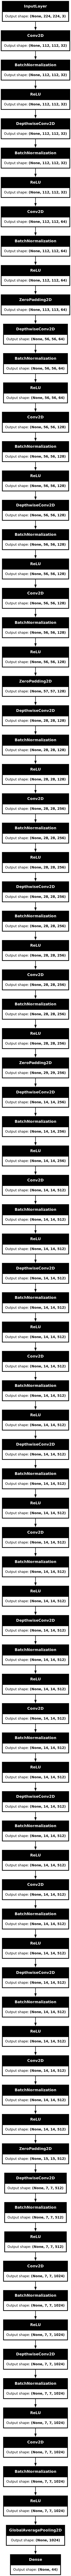

In [105]:
plot_model(model, show_shapes=True)

In [106]:
from keras.metrics import Precision, Recall, AUC
import tensorflow as tf
from keras import backend as K

In [107]:
import tensorflow.keras.backend as k

def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + k.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + k.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + k.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = k.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + k.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return k.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return k.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return k.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return k.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = k.round(k.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = k.round(k.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

In [108]:
custom_metrics = list(create_metrics())
custom_metrics.append("accuracy")

In [109]:
model.compile(
    optimizer = Adam(learning_rate = 5e-4),
    loss = 'categorical_crossentropy',
    metrics = custom_metrics
#         metrics = custom_metrics

)

In [110]:
class TimeCallback(tf.keras.callbacks.Callback):
    """Custom callback to record epoch times and total training time."""

    def on_train_begin(self, logs=None):
        """Initialize training start time and epoch times."""
        self.train_start_time = time.perf_counter()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        """Record start time of each epoch."""
        self.epoch_start_time = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        """Calculate and store epoch time."""
        epoch_time = time.perf_counter() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs=None):
        """Calculate total training time."""
        self.total_train_time = time.perf_counter() - self.train_start_time

# Create an instance of the TimeCallback
time_callback = TimeCallback()

In [111]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch,lr):
    if epoch < 12:
        return lr
    else:
        return 0.9*lr


lr_scheduler = LearningRateScheduler(lr_schedule)

In [112]:
TOTAL_EPOCHS = 25

start_time = perf_counter()
history = model.fit(
    train_gen,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=valid_gen,
    validation_steps=val_steps,
    callbacks=[time_callback]
)
warnings.filterwarnings("ignore")
end_time = perf_counter()

Epoch 1/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.2478 - auc_3: 0.7707 - f1_score: 0.2018 - loss: 3.2452 - mcc: 0.2364 - precision_3: 0.5089 - recall_3: 0.1390 - sensitivity: 0.1372 - specificity: 0.9974 - val_accuracy: 0.3125 - val_auc_3: 0.8214 - val_f1_score: 0.3283 - val_loss: 3.1072 - val_mcc: 0.3450 - val_precision_3: 0.4787 - val_recall_3: 0.2557 - val_sensitivity: 0.2557 - val_specificity: 0.9935
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6250 - auc_3: 0.9004 - f1_score: 0.6154 - loss: 1.9724 - mcc: 0.6261 - precision_3: 0.8000 - recall_3: 0.5000 - sensitivity: 0.5000 - specificity: 0.9971 - val_accuracy: 0.5000 - val_auc_3: 0.7020 - val_f1_score: 0.5714 - val_loss: 3.7561 - val_mcc: 0.5690 - val_precision_3: 0.6667 - val_recall_3: 0.5000 - val_sensitivity: 0.5000 - val_specificity: 0.9942
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7348 - auc_3: 0.9832 - f1_score: 0.7276 - loss: 0.9267 - mcc: 0.7372 - precision_3: 0.8

In [113]:
execution_time_parts = []
avg_time_parts = []

for unit in [(3600, 'hours'), (60, 'minutes'), (1, 'seconds'), (0.001, 'milliseconds')]:
    total_value = int(time_callback.total_train_time // unit[0])
    avg_value = int(np.mean(time_callback.epoch_times) // unit[0])

    if total_value > 0 or unit[0] == 0.001:
        execution_time_parts.append((total_value, unit[1]))
    if avg_value > 0 or unit[0] == 0.001:
        avg_time_parts.append((avg_value, unit[1]))

    time_callback.total_train_time -= total_value * unit[0]
    time_callback.epoch_times = [time - avg_value * unit[0] for time in time_callback.epoch_times]

execution_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in execution_time_parts if value > 0
])

avg_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in avg_time_parts if value > 0
])

print(f"Model training took {execution_time_string}")
print(f"Average time per epoch: {avg_time_string}")

Model training took 01 minutes, 25 seconds, 964 milliseconds
Average time per epoch: 03 seconds, 420 milliseconds


In [114]:
_ = model.evaluate(test_gen, steps = test_steps)

112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7318 - auc_3: 0.9704 - f1_score: 0.7444 - loss: 1.0462 - mcc: 0.7441 - precision_3: 0.8185 - recall_3: 0.6896 - sensitivity: 0.6896 - specificity: 0.9964


In [115]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

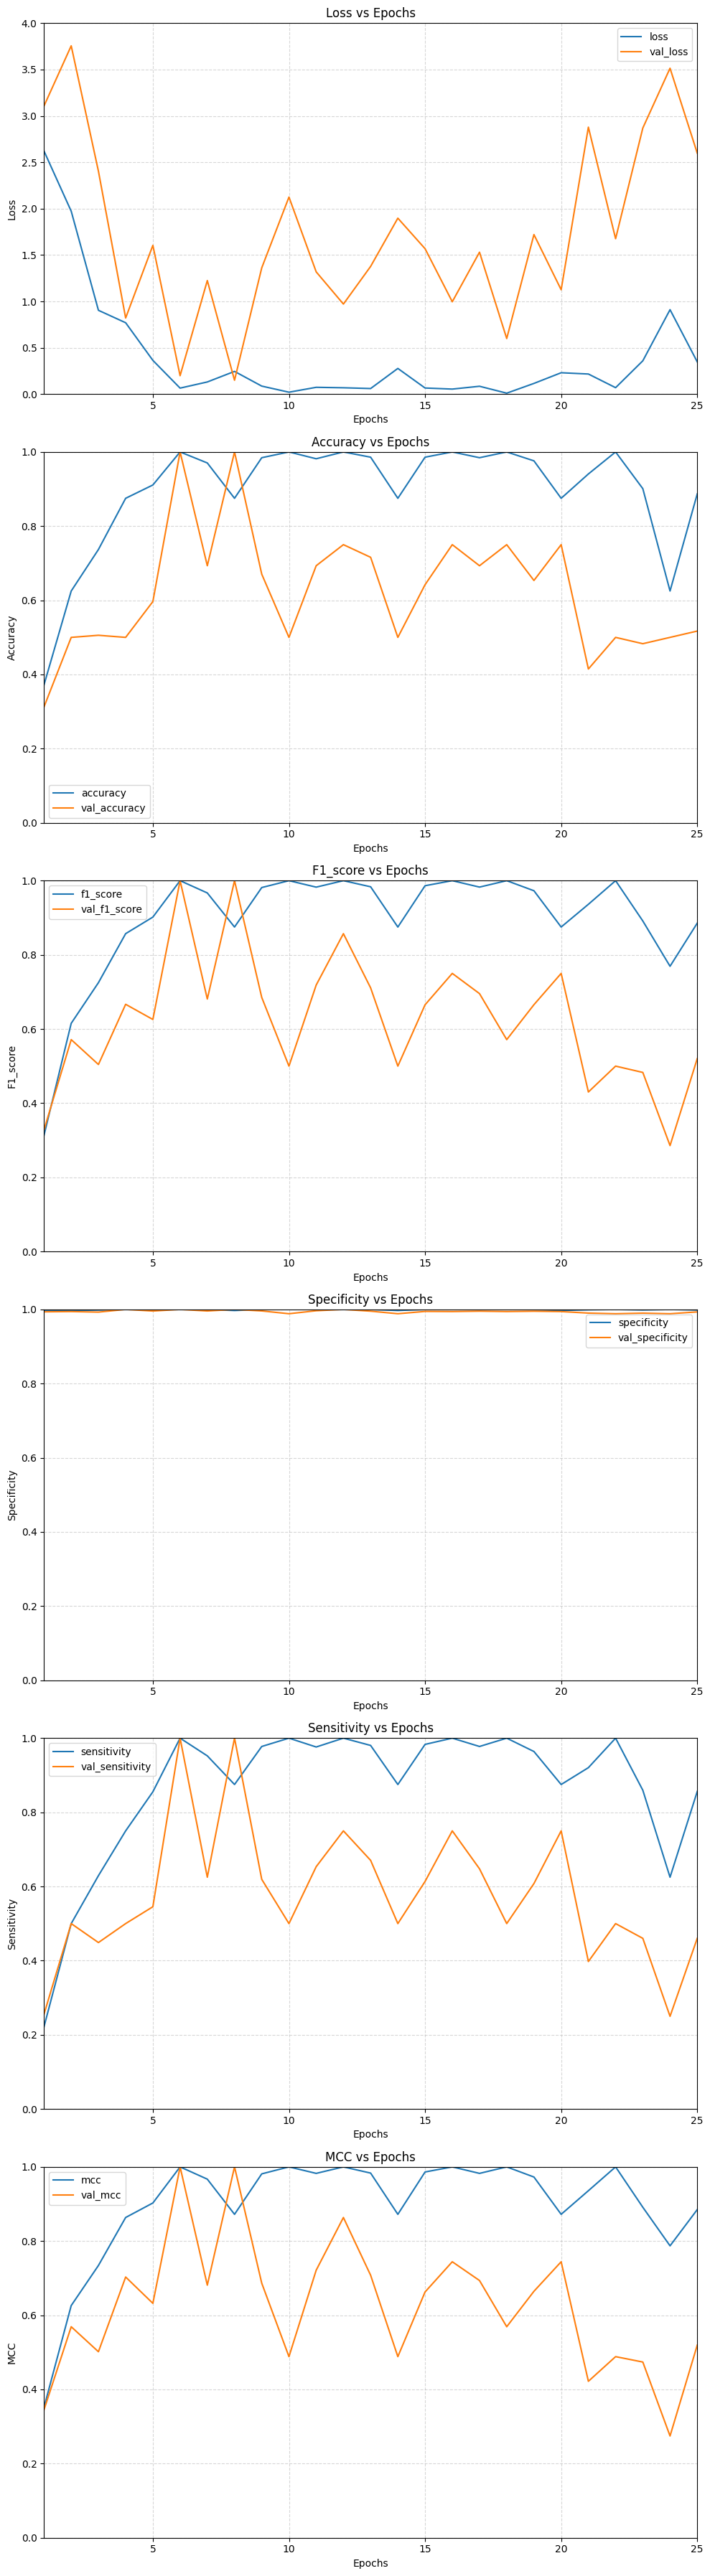

In [116]:
metric_names = ["loss", "accuracy","f1_score",
                "specificity", "sensitivity", "mcc"]
plot_metrics(history, metric_names)

In [117]:
def generate_classification_report(model, test_generator, test_steps, batch_size, target_names):
    """
    Generate a classification report, accuracy, and number of errors for a given model and test generator.

    Args:
        model (object): The trained model.
        test_generator (object): The test data generator.
        test_steps (int): The number of steps to iterate over the test generator.
        batch_size (int): The batch size for generating predictions.
        target_names (list): List of target class names for the classification report.

    Returns:
        tuple: A tuple containing true labels, predicted labels, and the classification report.
    """
    predicted_labels = []
    true_labels = []

    for i in range(test_steps):
        batch_data, batch_true_labels = next(test_generator)

        batch_predicted_labels = model.predict_on_batch(batch_data)
        batch_predicted_labels = np.argmax(batch_predicted_labels, axis=1)

        predicted_labels.extend(batch_predicted_labels)
        true_labels.extend(batch_true_labels)

    true_labels = np.array(true_labels)

    if len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)

    report = classification_report(
        true_labels,
        predicted_labels,
        target_names=target_names,
        digits=4,
        zero_division=1
    )

    accuracy = accuracy_score(true_labels, predicted_labels)
    num_errors = np.sum(true_labels != predicted_labels)

    print(report)
    print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

    return true_labels, predicted_labels

In [118]:
true_labels, predicted_labels = generate_classification_report(
    model, test_gen, test_steps, BATCH_SIZE, df["label"].unique()
)

                        precision    recall  f1-score   support

        Astrocitoma T1     0.8000    0.8000    0.8000        35
      Astrocitoma T1C+     0.8723    0.8913    0.8817        46
        Astrocitoma T2     0.6471    0.9706    0.7765        34
          Carcinoma T1     0.8667    1.0000    0.9286        13
        Carcinoma T1C+     0.9375    0.6818    0.7895        22
          Carcinoma T2     1.0000    0.0667    0.1250        15
         Ependimoma T1     1.0000    0.1111    0.2000         9
       Ependimoma T1C+     1.0000    0.4000    0.5714        10
         Ependimoma T2     0.6000    0.8182    0.6923        11
      Ganglioglioma T1     0.6000    0.7500    0.6667         4
    Ganglioglioma T1C+     1.0000    0.3333    0.5000         3
      Ganglioglioma T2     1.0000    0.0000    0.0000         5
          Germinoma T1     1.0000    0.4000    0.5714         5
        Germinoma T1C+     0.3333    1.0000    0.5000         8
          Germinoma T2     0.2222    0.

In [119]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    """
    Compute the confusion matrix.

    Args:
        true_labels (list or numpy.ndarray): Array-like object of true labels.
        predicted_labels (list or numpy.ndarray): Array-like object of predicted labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Confusion matrix.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    np.add.at(cm, (true_labels, predicted_labels), 1)
    return cm

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels= df["label"].unique(), yticklabels= df["label"].unique())

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()